# **Technical Test - Telematika Indonesia**

**Overview**
- Membuat model NLP (*Natural Language Processing*) yang mampu mendapatkan informasi tertentu dari kalimat-kalimat yang diberikan.
- Contoh Kalimat Masukan:
 1. "Saya mau memesan 5 piring dan 4 gelas denganmotif floral"

 Keluaran yang Diharapkan:

 Jumlah barang: 5; 4

 Nama barang:piring; gelas

 Motif: Floral

- Berdasarkan hal tersebut, asus ini dapat diselesaikan menggunakan Named Entity Recognition (NER). Metode yang saya gunakan yaitu menggunkan pendekatan transformers yaitu model IndoBERT, model BERT yang sudah dioptimalkan untuk bahsa Indonesia.

# Import Library dan Data

In [1]:
# Import Libarary
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
# Membaca data data
data = pd.read_csv("ner_dataset.csv")

data.head()

,kalimat,label
0,saya ingin memesan 3 gelas dan 7 piring dengan...,0 0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0...
1,tolong antar 15 piring dan 5 gelas dengan moti...,0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 0...
2,saya memesan 8 gelas dan 12 piring dengan moti...,0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 0...
3,kirimkan 4 piring dengan motif geometris ke yo...,0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-LOCATION
4,saya ingin 5 gelas dengan motif bunga dan 3 pi...,0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-QUANTIT...


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   kalimat  350 non-null    object
 1   label    350 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB
None


# Data Preprocessing
## Data Cleansing

In [4]:
# Menghapus baris yang kosong (untuk baris kosong di antara token)
data = data.dropna()

# Menyaring baris kosong di kolom Word atau Label
data = data[(data['kalimat'] != '') & (data['label'] != '')]

# Memeriksa hasilnya
data

,kalimat,label
0,saya ingin memesan 3 gelas dan 7 piring dengan...,0 0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0...
1,tolong antar 15 piring dan 5 gelas dengan moti...,0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 0...
2,saya memesan 8 gelas dan 12 piring dengan moti...,0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 0...
3,kirimkan 4 piring dengan motif geometris ke yo...,0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-LOCATION
4,saya ingin 5 gelas dengan motif bunga dan 3 pi...,0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-QUANTIT...
...,...,...
345,saya membutuhkan 4 cangkir dengan motif minima...,0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-LOCATION
346,tolong kirim 6 sendok dengan motif polkadot ke...,0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 B-LOCATION
347,pesan 8 mangkuk dengan motif garis,0 B-QUANTITY B-ITEM 0 0 B-MOTIF
348,saya ingin memesan 5 piring dengan motif bunga...,0 0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF


In [5]:
# Menghapus spasi di sekitar nilai dalam kolom kalimat dan label
data['kalimat'] = data['kalimat'].astype(str).str.strip()
data['label'] = data['label'].astype(str).str.strip()

In [6]:
# Example to check the alignment between sentences and labels
# Check if the number of words in a sentence matches the number of labels
for index, row in data.iterrows():
  if len(row['kalimat'].split()) != len(row['label'].split()):
    print(f"Mismatch at index {index}:")
    print(f"Sentence: {row['kalimat']}")
    print(f"Label: {row['label']}")
    print(f"Sentence length: {len(row['kalimat'].split())}")
    print(f"Label length: {len(row['label'].split())}")
    print("---")

Mismatch at index 38:
Sentence: saya butuh 10 gelas dengan motif marmer
Label: 0 0 B-QUANTITY B-ITEM 0 0B-MOTIF
Sentence length: 7
Label length: 6
---
Mismatch at index 44:
Sentence: pesan 15 piring dan 2 gelas dengan motif garis
Label: 0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 0 B-MOTIF
Sentence length: 9
Label length: 10
---
Mismatch at index 46:
Sentence: pesan 12 gelas dengan motif geometris untuk dikirim ke jakarta
Label: 0 B-QUANTITY B-ITEM 0 B-MOTIF 0 0 0 B-LOCATION
Sentence length: 10
Label length: 9
---
Mismatch at index 53:
Sentence: pesan 3 piring dan 10 gelas bermotif bunga
Label: 0 0 B-QUANTITY B-ITEM 0 B-QUANTITY B-ITEM 0 B-MOTIF
Sentence length: 8
Label length: 9
---
Mismatch at index 57:
Sentence: siapkan 7 gelas dengan motif floral
Label: 0 B-QUANTITY B-ITEM 0 B-MOTIF
Sentence length: 6
Label length: 5
---
Mismatch at index 115:
Sentence: tolong siapkan 8 piring dengan motif garis untuk acara di bandung
Label: 0 0 B-QUANTITY B-ITEM 0 0 B-MOTIF 0 0 0 B-LOCATION I-LOCA

In [7]:
# Hapus baris dengan jumlah kata dan label yang tidak sama
indices_to_drop = []
for index, row in data.iterrows():
    if len(row['kalimat'].split()) != len(row['label'].split()):
        indices_to_drop.append(index)

data = data.drop(indices_to_drop)

# Memeriksa hasil
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 0 to 349
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   kalimat  238 non-null    object
 1   label    238 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB
None


In [8]:
# Membuat list kosong untuk menyimpan hasil pemecahan kata dan label
expanded_data = []

# Loop setiap baris dalam DataFrame dan tambahkan indeks kalimat
for index, row in data.iterrows():
    # Memecah kalimat menjadi kata-kata
    words = row['kalimat'].split()
    # Memecah label menjadi label masing-masing kata
    labels = row['label'].split()

    # Memastikan jumlah kata dan label sama
    if len(words) == len(labels):
        for word, label in zip(words, labels):
            expanded_data.append([index, word, label])  # Menyimpan indeks kalimat asli
    else:
        print(f"Jumlah kata dan label tidak sama di baris {index}")

# Membuat DataFrame baru dari data yang sudah diperluas
expanded_data = pd.DataFrame(expanded_data, columns=['kalimat', 'kata', 'label'])
expanded_data

,kalimat,kata,label
0,0,saya,0
1,0,ingin,0
2,0,memesan,0
3,0,3,B-QUANTITY
4,0,gelas,B-ITEM
...,...,...,...
2226,349,dengan,0
2227,349,motif,0
2228,349,floral,B-MOTIF
2229,349,ke,0


In [9]:
# List untuk menyimpan hasil akhir
result = []

# Kelompokkan berdasarkan 'Kalimat_Index' dan tambahkan baris kosong di antara kalimat
for _, group in expanded_data.groupby("kalimat"):
    result.append(group)       # Tambahkan kalimat ke dalam hasil
    result.append(pd.DataFrame([["", "", ""]], columns=expanded_data.columns))  # Tambahkan baris kosong

# Gabungkan semua menjadi satu DataFrame
df = pd.concat(result, ignore_index=True)

# Menghapus kolom kalimat
df = df.drop(columns=["kalimat"])

# Simpan ke file baru atau tampilkan
df.to_csv("ner_dataset_with_blank_lines.txt", index=False, header=False, sep="\t")

## Import tranformers

In [10]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [11]:
!pip install transformers

In [12]:
# Mengimport ulang data
df = pd.read_csv("ner_dataset_with_blank_lines.txt", sep='\t', header=None, names=['kata', 'label'])

## Membuat Dataset Sequence

In [13]:
# List untuk menyimpan kalimat dan label
sentences = []
labels = []
sentence = []
label_sequence = []

for _, row in df.iterrows():
    word, label = row['kata'], row['label']

    # Jika ditemukan baris dengan NaN di kedua kolom, anggap sebagai pemisah kalimat
    if pd.isna(word) and pd.isna(label):
        if sentence:  # Menyimpan kalimat jika tidak kosong
            sentences.append(sentence)
            labels.append(label_sequence)
            sentence = []
            label_sequence = []
    else:
        sentence.append(word)
        label_sequence.append(label)

In [14]:
# Contoh: menampilkan kalimat pada indeks ke-2
index = 5

# Pastikan indeks ada dalam rentang yang benar
if index < len(sentences):
    print("Kalimat:", sentences[index])
    print("Label:", labels[index])
else:
    print("Indeks tidak valid.")

Kalimat: ['tolong', 'siapkan', '20', 'piring', 'dengan', 'motif', 'garis', 'untuk', 'acara', 'di', 'jakarta', 'pusat']
Label: ['0', '0', 'B-QUANTITY', 'B-ITEM', '0', '0', 'B-MOTIF', '0', '0', '0', 'B-LOCATION', 'I-LOCATION']


In [15]:
print("Number of training sentences: {:,}".format(len(sentences)))

Number of training sentences: 238


## Tokenisasi Menggunakan BERT

In [16]:
# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
tokenizer.encode(sentences[1])

[2, 3854, 2563, 970, 10399, 41, 418, 6387, 79, 4997, 3898, 43, 1574, 3]

In [19]:
tokenizer.decode([2, 3854, 6981, 165, 10399, 79, 4997, 2995, 90, 1546, 26, 678, 1417, 3])

'[CLS] tolong siapkan 20 piring dengan motif garis untuk acara di jakarta pusat [SEP]'

## Pembuatan Padding,Truncation dan Attention Mask

In [20]:
TokenLength=[len(tokenizer.encode(' '.join(i),add_special_tokens=True)) for i in sentences]

In [21]:
print('Minimum  length: {:,} tokens'.format(min(TokenLength)))
print('Maximum length: {:,} tokens'.format(max(TokenLength)))
print('Median length: {:,} tokens'.format(int(np.median(TokenLength))))

Minimum  length: 8 tokens
Maximum length: 15 tokens
Median length: 12 tokens


In [22]:
# Mapping labels ke integer satu kali
label_map = {label: i for i, label in enumerate(set(label for label_seq in labels for label in label_seq))}
null_label_id = -100

In [23]:
# Encoding seluruh kalimat sekaligus menggunakan batch_encode_plus
encoded_inputs = tokenizer.batch_encode_plus(
    [' '.join(sent) for sent in sentences],
    add_special_tokens=True,
    truncation=True,
    max_length=15,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt'
)

# Menyimpan hasil encoding dan attention mask
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [24]:
# Menyesuaikan label dengan padding label null (-100)
new_labels = []

for sent, orig_labels in zip(input_ids, labels):
    padded_labels = []
    orig_labels_i = 0

    for token_id in sent:
        token_id = token_id.item()

        # Beri label null pada token padding, CLS, dan SEP
        if token_id in {tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id}:
            padded_labels.append(null_label_id)
        elif tokenizer.convert_ids_to_tokens(token_id).startswith("##"):
            padded_labels.append(null_label_id)
        # Check if we've run out of labels to assign
        elif orig_labels_i < len(orig_labels):
            label_str = orig_labels[orig_labels_i]
            padded_labels.append(label_map[label_str])
            orig_labels_i += 1
        else: #Assign null labels to remaining tokens.
            padded_labels.append(null_label_id)

    new_labels.append(padded_labels)

In [25]:
# Verifikasi hasil
print('\nSentence:    ', sentences[1])
print('\nLabels:      ', labels[1])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences[1])))
print('\nToken IDs:   ', input_ids[1])
print('\nNew Labels:  ', new_labels[1])
print('\nMask:        ', attention_masks[1])



Sentence:     ['tolong', 'antar', '15', 'piring', 'dan', '5', 'gelas', 'dengan', 'motif', 'batik', 'ke', 'bandung']

Labels:       ['0', '0', 'B-QUANTITY', 'B-ITEM', '0', 'B-QUANTITY', 'B-ITEM', '0', '0', 'B-MOTIF', '0', 'B-LOCATION']

BERT Tokens:  ['tolong', 'antar', '15', 'piring', 'dan', '5', 'gelas', 'dengan', 'motif', 'batik', 'ke', 'bandung']

Token IDs:    tensor([    2,  3854,  2563,   970, 10399,    41,   418,  6387,    79,  4997,
         3898,    43,  1574,     3,     0])

New Labels:   [-100, 4, 4, 0, 1, 4, 0, 1, 4, 4, 2, 4, 3, -100, -100]

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


Convert the lists into PyTorch tensors using torch.stack

In [26]:
# Menggabungkan urutan tensor untuk dimensi baru
pt_input_ids = input_ids

pt_attention_masks = attention_masks

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [27]:
from torch.utils.data import TensorDataset, random_split

# Menggabungkan input pelatihan ke dalam TensorDataset
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# CBuat pembagian validasi latih dan latih 90-10
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Membagi dataset dengan memilih sampel secara acak
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  214 training samples
   24 validation samples


Mengkonversi tensor menjadi Batch untuk data pelatihan berdasarkan menggunakan RandomSampler untuk memilih batch secara acak

In [28]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

Menggunakan IndoBER dan AdamW untuk Optimizer

In [29]:
from transformers import BertForTokenClassification, AdamW, BertConfig

model = BertForTokenClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels = len(label_map) + 1, output_attentions = False, output_hidden_states = False)
model.cuda()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [30]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [32]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))

======== Epoch 1 / 3 ========
Training...
  Average training loss: 0.32
======== Epoch 2 / 3 ========
Training...
  Average training loss: 0.02
======== Epoch 3 / 3 ========
Training...
  Average training loss: 0.02


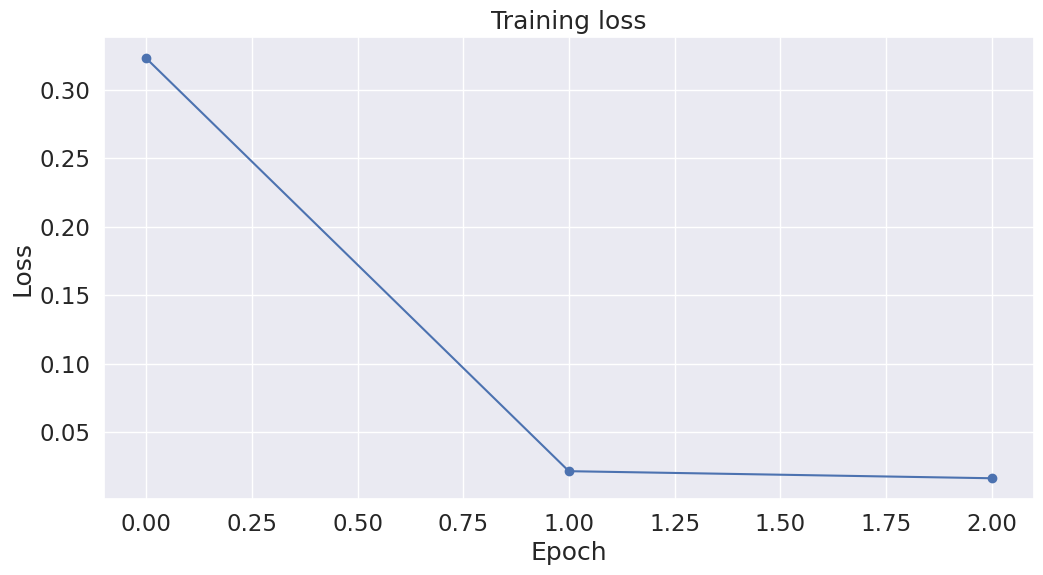

In [33]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test Data

In [34]:
# Mengimport ulang data
df_test = pd.read_csv("ner_dataset_test.txt", sep='\t', header=None, names=['kata', 'label'])

In [35]:
df_test

,kata,label
0,Saya,0
1,ingin,0
2,9,B-QUANTITY
3,piring,B-ITEM
4,dengan,0
...,...,...
544,motif,0
545,bunga,B-MOTIF
546,dikirim,0
547,ke,0


In [36]:
# List untuk menyimpan kalimat dan label
sentences_test = []
labels_test = []
sentence_test = []
label_sequence_test = []

for _, row in df_test.iterrows():
    word, label = row['kata'], row['label']

    # Jika ditemukan baris dengan NaN di kedua kolom, anggap sebagai pemisah kalimat
    if pd.isna(word) and pd.isna(label):
        if sentence_test:  # Menyimpan kalimat jika tidak kosong
            sentences_test.append(sentence_test)
            labels_test.append(label_sequence_test)
            sentence_test = []
            label_sequence_test = []
    else:
        sentence_test.append(word)
        label_sequence_test.append(label)

In [37]:
# Contoh: menampilkan kalimat pada indeks ke-2
index = 0

# Pastikan indeks ada dalam rentang yang benar
if index < len(sentences_test):
    print("Kalimat:", sentences_test[index])
    print("Label:", labels_test[index])
else:
    print("Indeks tidak valid.")

Kalimat: ['Saya', 'ingin', '9', 'piring', 'dengan', 'motif', 'bunga', 'dikirim', 'ke', 'Bandung']
Label: ['0', '0', 'B-QUANTITY', 'B-ITEM', '0', '0', 'B-MOTIF', '0', '0', 'B-LOCATION']


In [38]:
print("Number of training sentences: {:,}".format(len(sentences_test)))

Number of training sentences: 49


In [39]:
# Encoding seluruh kalimat sekaligus menggunakan batch_encode_plus
encoded_inputs = tokenizer.batch_encode_plus(
    [' '.join(sent) for sent in sentences_test],
    add_special_tokens=True,
    truncation=True,
    max_length=15,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt'
)

# Menyimpan hasil encoding dan attention mask
input_ids_test = encoded_inputs['input_ids']
attention_masks_test = encoded_inputs['attention_mask']

# Menampilkan
print('Original: ', sentences_test[0])
print('Token IDs:', input_ids_test[0])
print('Masks:', attention_masks_test[0])

Original:  ['Saya', 'ingin', '9', 'piring', 'dengan', 'motif', 'bunga', 'dikirim', 'ke', 'Bandung']
Token IDs: tensor([    2,   209,   561,   874, 10399,    79,  4997,  1968,  3656,    43,
         1574,     3,     0,     0,     0])
Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])


In [40]:
# Menyesuaikan label dengan padding label null (-100)
new_labels_test = []

null_label_id = -100

for (sen, orig_labels) in zip(input_ids_test, labels_test):
    padded_labels = []
    orig_labels_i = 0

    for token_id in sen:
        token_id = token_id.numpy().item()

        if (token_id == tokenizer.pad_token_id) or \
            (token_id == tokenizer.cls_token_id) or \
            (token_id == tokenizer.sep_token_id):

            padded_labels.append(null_label_id)

        elif tokenizer.ids_to_tokens[token_id][0:2] == '##':
            padded_labels.append(null_label_id)

        else:
            label_str = orig_labels[orig_labels_i]
            padded_labels.append(label_map[label_str])
            orig_labels_i += 1

    assert(len(sen) == len(padded_labels))

    new_labels_test.append(padded_labels)

In [41]:
print('\nSentence:    ', sentences_test[0])
print('\nLabels:      ', labels_test[0])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(sentences_test[0])))
print('\nToken IDs:   ', input_ids_test[0])
print('\nMask:        ', attention_masks_test[0])
print('\nNew Labels:  ', new_labels[0])


Sentence:     ['Saya', 'ingin', '9', 'piring', 'dengan', 'motif', 'bunga', 'dikirim', 'ke', 'Bandung']

Labels:       ['0', '0', 'B-QUANTITY', 'B-ITEM', '0', '0', 'B-MOTIF', '0', '0', 'B-LOCATION']

BERT Tokens:  ['saya', 'ingin', '9', 'piring', 'dengan', 'motif', 'bunga', 'dikirim', 'ke', 'bandung']

Token IDs:    tensor([    2,   209,   561,   874, 10399,    79,  4997,  1968,  3656,    43,
         1574,     3,     0,     0,     0])

Mask:         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])

New Labels:   [-100, 4, 4, 4, 0, 1, 4, 0, 1, 4, 4, 2, -100, -100, -100]


In [42]:
# input_ids_test is already a tensor, no need to stack
pt_input_ids_test = input_ids_test

# attention_masks_test is also already a tensor
pt_attention_masks_test = attention_masks_test

pt_labels_test = torch.tensor(new_labels_test, dtype=torch.long)

In [43]:
print("pt_input_ids_test size:", pt_input_ids_test.size())
print("pt_attention_masks_test size:", pt_attention_masks_test.size())
print("pt_labels_test size:", pt_labels_test.size())

pt_input_ids_test size: torch.Size([49, 15])
pt_attention_masks_test size: torch.Size([49, 15])
pt_labels_test size: torch.Size([49, 15])


In [44]:
batch_size = 16

prediction_data = TensorDataset(pt_input_ids_test, pt_attention_masks_test, pt_labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [45]:
# Menampilkan jumlah kalimat yang akan diprediksi.
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Menyetel model ke mode evaluasi. Ini penting agar model tidak melakukan backpropagation dan dropout saat prediksi.
model.eval()

# Inisialisasi daftar kosong untuk menyimpan prediksi dan label sebenarnya.
predictions, true_labels = [], []

# Looping melalui setiap batch data di `prediction_dataloader`.
for batch in prediction_dataloader:
    # Memindahkan setiap tensor dalam batch ke perangkat yang digunakan (misalnya, GPU jika tersedia).
    batch = tuple(t.to(device) for t in batch)

    # Memisahkan input ID, attention mask, dan label dari batch.
    b_input_ids, b_input_mask, b_labels = batch

    # Menonaktifkan perhitungan gradien agar proses prediksi lebih cepat dan hemat memori.
    with torch.no_grad():
        # Melakukan prediksi dengan model. Menggunakan input ID dan attention mask.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Mengambil output logit dari model (hasil mentah sebelum dikonversi menjadi probabilitas).
    logits = outputs[0]

    # Memindahkan logits dan label ke CPU dan mengonversinya menjadi numpy array untuk memudahkan pengolahan.
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Menyimpan hasil prediksi logits dan label sebenarnya.
    predictions.append(logits)
    true_labels.append(label_ids)

# Menampilkan pesan bahwa proses prediksi selesai.
print('    DONE.')

Predicting labels for 238 test sentences...
    DONE.


In [46]:
from sklearn.metrics import f1_score

# Menggabungkan hasil prediksi dari seluruh batch.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("Setelah menggabungkan seluruh batch, bentuk prediksi adalah:")
print("    ", all_predictions.shape)

# Mengambil label dengan skor tertinggi untuk setiap token
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nSetelah memilih label dengan skor tertinggi untuk setiap token:")
print("    ", predicted_label_ids.shape)

# Menghilangkan dimensi pertama untuk meratakan prediksi dan label
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nSetelah meratakan prediksi dan label menjadi bentuk:")
print("    Prediksi:", predicted_label_ids.shape)
print("    Ground truth:", all_true_labels.shape)

# Filter padding label (-100) dari hasil sebelum menghitung F1
mask = all_true_labels != -100
filtered_predictions = predicted_label_ids[mask]
filtered_true_labels = all_true_labels[mask]

# Menghitung skor F1
f1 = f1_score(filtered_true_labels, filtered_predictions, average='weighted')
print("\nSkor F1 (Weighted):", f1)


Setelah menggabungkan seluruh batch, bentuk prediksi adalah:
     (49, 15, 7)

Setelah memilih label dengan skor tertinggi untuk setiap token:
     (49, 15)

Setelah meratakan prediksi dan label menjadi bentuk:
    Prediksi: (735,)
    Ground truth: (735,)

Skor F1 (Weighted): 1.0


In [47]:
# Inisialisasi daftar kosong untuk menyimpan prediksi dan label sebenarnya tanpa token 'null'.
real_token_predictions = []
real_token_labels = []

# Loop melalui semua label yang benar (true labels) yang ada.
for i in range(len(all_true_labels)):

    # Memeriksa apakah label saat ini bukan -100.
    # Label -100 biasanya digunakan untuk token yang seharusnya diabaikan, seperti padding.
    if not all_true_labels[i] == -100:

        # Menyimpan prediksi dan label yang valid (bukan -100) ke dalam daftar.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

# Menampilkan jumlah label sebelum dan sesudah token 'null' (dengan label -100) disaring.
print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 735
 After filtering out `null` tokens, length = 490


In [48]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro')

print ("F1 score: {:.2%}".format(f1))

F1 score: 100.00%


In [49]:
# Input kalimat
test_sentence = input("Kalimat: ")

# Encoding dan konversi kalimat ke tensor
sample_sentence = tokenizer.encode(test_sentence, add_special_tokens=True)
sample_input_ids = torch.tensor([sample_sentence])

# Pastikan model berada di device yang sesuai (CPU atau GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sample_input_ids = sample_input_ids.to(device)
model.to(device)

# Melakukan prediksi dengan model
with torch.no_grad():
    output = model(sample_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# Fungsi untuk mendapatkan key dari label dictionary
def get_key(val):
    for key, value in label_map.items():
        if val == value:
            return key
    return "O"  # Label default untuk token yang tidak dikenal

# Tokenisasi
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token in ["[CLS]", "[SEP]", "[PAD]"]:
        # Beri label "O" untuk token spesial
        new_tokens.append(token)
        new_labels.append("O")
    else:
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]  # Menggabungkan subword token
        else:
            new_tokens.append(token)
            new_labels.append(get_key(label_idx))

# Membuat DataFrame untuk menyimpan hasil prediksi
df = pd.DataFrame({"Token": new_tokens, "Predicted_Label": new_labels})
print(df.T)


Kalimat: saya mau memesan 5 piring dan 4 gelas dengan motif floral
                    0     1    2        3           4       5    6   \
Token            [CLS]  saya  mau  memesan           5  piring  dan   
Predicted_Label      O     0    0        0  B-QUANTITY  B-ITEM    0   

                         7       8       9      10       11     12  
Token                     4   gelas  dengan  motif   floral  [SEP]  
Predicted_Label  B-QUANTITY  B-ITEM       0      0  B-MOTIF      O  


In [50]:
import os

model_path = "ner_indobert_model"
os.makedirs(model_path, exist_ok=True)

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('ner_indobert_model/tokenizer_config.json',
 'ner_indobert_model/special_tokens_map.json',
 'ner_indobert_model/vocab.txt',
 'ner_indobert_model/added_tokens.json')

In [51]:
import shutil

# Kompres folder model ke file ZIP
shutil.make_archive("ner_indobert_model", 'zip', "ner_indobert_model")

'/content/ner_indobert_model.zip'